In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement=Base.classes.measurement
Station= Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
# select date from measurement order by date desc limit 1;
from sqlalchemy import desc
most_recent_row = session.query(Measurement).order_by(desc(Measurement.date)).first()
most_recent_row.date

'2017-08-23'

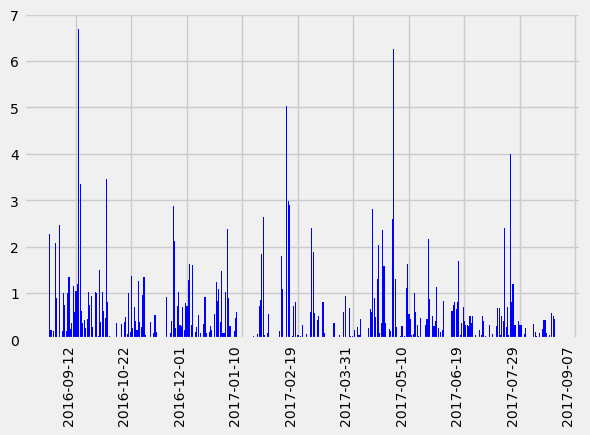

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_row.date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_delta = dt.timedelta(days=365)
starting_date = most_recent_date - one_year_delta
starting_date

# Perform a query to retrieve the data and precipitation scores
# SELECT
# 	measurement.date, measurement.prcp
# FROM 
# 	measurement 
# WHERE 
# 	measurement.date >= '2016-08-26'
results = session.query(Measurement).filter(Measurement.date >= starting_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = []
for row in results:
    data.append({
        "date": dt.datetime.strptime(row.date, "%Y-%m-%d"),
        "prcp": row.prcp
    })

df = pd.DataFrame(data)

# Sort the dataframe by date
df.sort_values(by=['date'], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=40))
plt.gcf().autofmt_xdate()

plt.bar(df['date'], df['prcp'], color="b", align="center")
plt.yticks(fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
# select count(*) from station
total_station_count = session.query(Station).count()
total_station_count

9

In [77]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Select station, count(station) from measurement group by station order by count(station) desc
from sqlalchemy import func
results = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [78]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results[0][0]
# select min(tobs), max(tobs), avg(tobs) from measurement where station = 'USC00519281'
result1 = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == results[0][0]).all()
result1

[(54.0, 85.0, 71.66378066378067)]

[ 5  7  7 12 27 41 40 57 66 52 29  8] [59. 61. 63. 65. 67. 69. 71. 73. 75. 77. 79. 81. 83.]


Text(0, 0.5, 'Frequency')

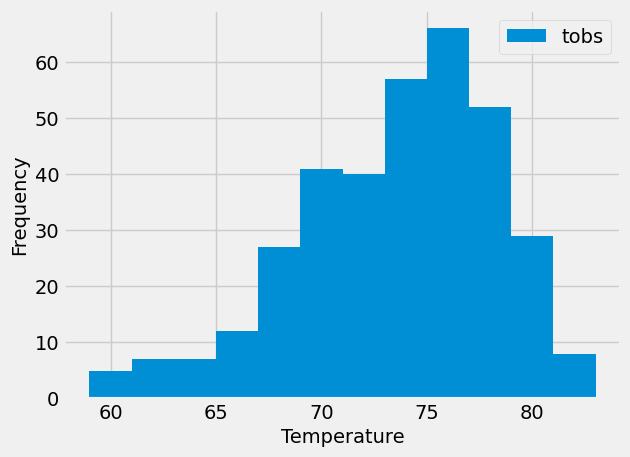

In [93]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# select tobs from measurement where date >= '2016-08-23' and station = 'USC00519281'
results2 = session.query(Measurement.tobs).filter(Measurement.date>=starting_date).filter(Measurement.station==results[0][0]).all()
dataset = []
for row in results2:
    dataset.append(row[0])
dataset

counts, bins = np.histogram(dataset, bins=12)
print(counts, bins)
plt.hist(bins[:-1], bins, weights=counts)
plt.legend(['tobs'])
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close Session

In [94]:
# Close Session
session.close()